In [1]:
############### Линейная регрессия ##########################

### Загрузка необходимых библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
### Загрузка данных
data = pd.read_csv('t4.csv', delimiter = ';')
data.head()


,id_t1,id_t2,timer,timers,height,distance,overload,speed
0,1,1,0:01:00,60,9,3,21,1530
1,1,1,0:01:01,61,10,4,21,1582
2,1,1,0:01:02,62,10,4,22,1634
3,1,1,0:01:03,63,11,4,22,1681
4,1,1,0:01:04,64,11,5,22,1735


In [3]:
data.drop (data.columns[[0,2]], axis= 1 , inplace= True )
data.head()


,id_t2,timers,height,distance,overload,speed
0,1,60,9,3,21,1530
1,1,61,10,4,21,1582
2,1,62,10,4,22,1634
3,1,63,11,4,22,1681
4,1,64,11,5,22,1735


In [4]:
from sklearn.model_selection import train_test_split

y = data['speed']
X = data.drop(columns=['speed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

y_test

152     9426
314    17199
214    13033
211    12833
381    20968
       ...  
97      7296
130     8466
459    26407
84      6934
377    20740
Name: speed, Length: 146, dtype: int64

<ipython-input-5-34f1dc3e7a15>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


<Axes: xlabel='speed', ylabel='Density'>

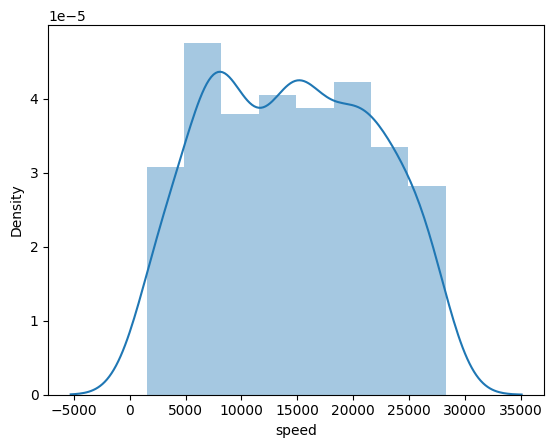

In [5]:
sns.distplot(y_train)

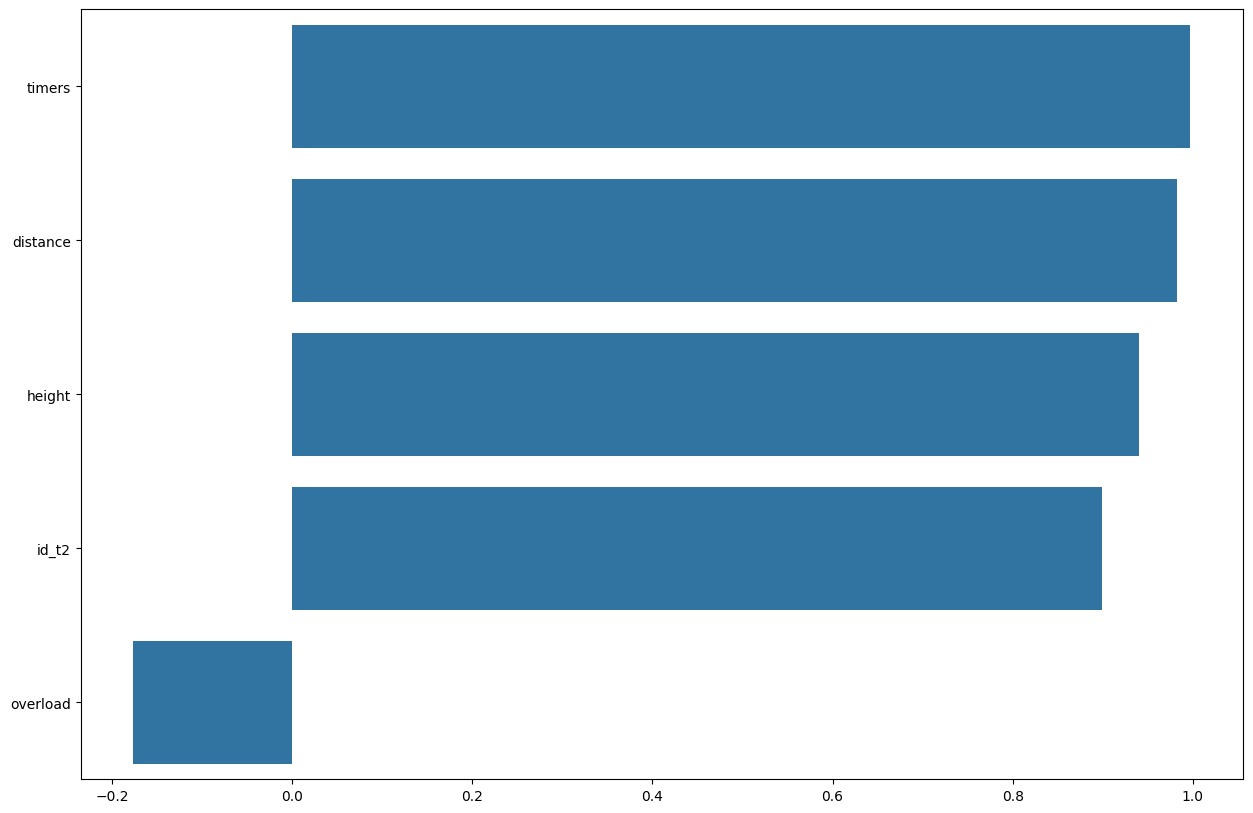

In [6]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)
correlations = {
feature: np.corrcoef(X_train[feature], y_train)[0][1]
for feature in numeric_features
}
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
features_order = [x[0] for x in sorted_correlations]
correlations = [x[1] for x in sorted_correlations]
plot = sns.barplot(y=features_order, x=correlations)
plot.figure.set_size_inches(15, 10)

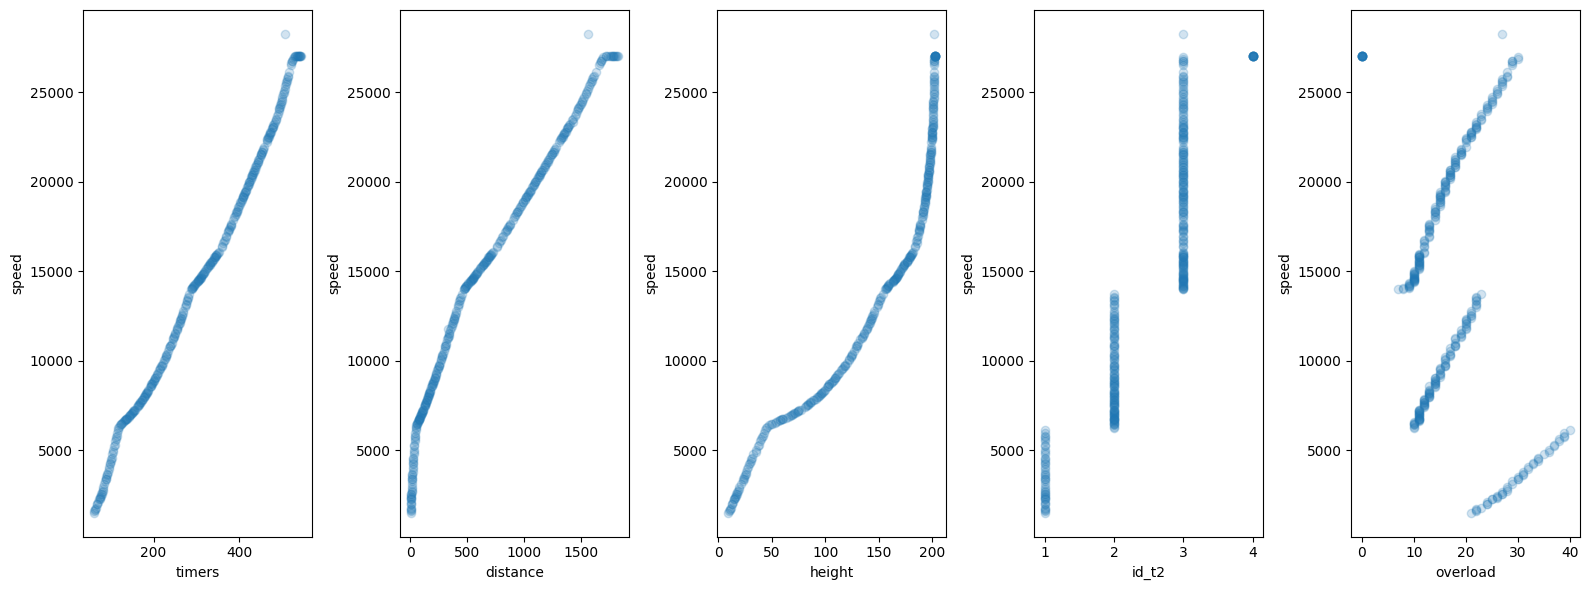

In [ ]:
fig, axs = plt.subplots(figsize=(16, 6), ncols=5)
for i, feature in enumerate(['timers', 'distance', 'height', 'id_t2', 'overload']):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('speed')
plt.tight_layout()

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])
print('Test MSE = %.4f' % mean_squared_error(y_test, y_pred))
print('Train MSE = %.4f' % mean_squared_error(y_train, y_train_pred))

Test MSE = 123523.6271
Train MSE = 119060.4308


In [8]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring='neg_mean_squared_error')
print('Cross validation scores:\n\t', '\n\t'.join('%.4f' % x for x in cv_scores))
print('Mean CV MSE = %.4f' % np.mean(-cv_scores))

Cross validation scores:
	 -80556.8598
	-128154.3439
	-376382.1592
	-72751.8549
	-79977.0324
	-90627.0955
	-69344.8330
	-102962.8582
	-117873.3637
	-107889.3146
Mean CV MSE = 122651.9715


In [9]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
  error = (y_true - y_pred) ** 2
  return np.sqrt(np.mean(error))
rmse_scorer = make_scorer(
  rmse,
  greater_is_better=False
)

In [10]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print('Test RMSE = %.4f' % rmse(y_test, y_pred))
print('Train RMSE = %.4f' % rmse(y_train, y_train_pred))

Test RMSE = 351.4593
Train RMSE = 345.0513


In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print('Cross validation scores:\n\t', '\n\t'.join('%.4f' % x for x in cv_scores))
print('Mean CV RMSE = %.4f' % np.mean(-cv_scores))

Cross validation scores:
	 -283.8254
	-357.9865
	-613.4999
	-269.7255
	-282.8021
	-301.0433
	-263.3341
	-320.8783
	-343.3269
	-328.4651
Mean CV RMSE = 336.4887


In [12]:
best_constant = y_train.mean()
print('Test RMSE with best constant = %.4f' % rmse(y_test, best_constant))
print('Train RMSE with best constant = %.4f' % rmse(y_train, best_constant))

Test RMSE with best constant = 6677.5499
Train RMSE with best constant = 7259.5014


In [13]:
def show_weights(features, weights, scales):
  fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
  sorted_weights = sorted(zip(weights, features, scales), reverse=True)
  weights = [x[0] for x in sorted_weights]
  features = [x[1] for x in sorted_weights]
  scales = [x[2] for x in sorted_weights]
  sns.barplot(y=features, x=weights, ax=axs[0])
  axs[0].set_xlabel('Weight')
  sns.barplot(y=features, x=scales, ax=axs[1])
  axs[1].set_xlabel('Scale')
  plt.tight_layout()

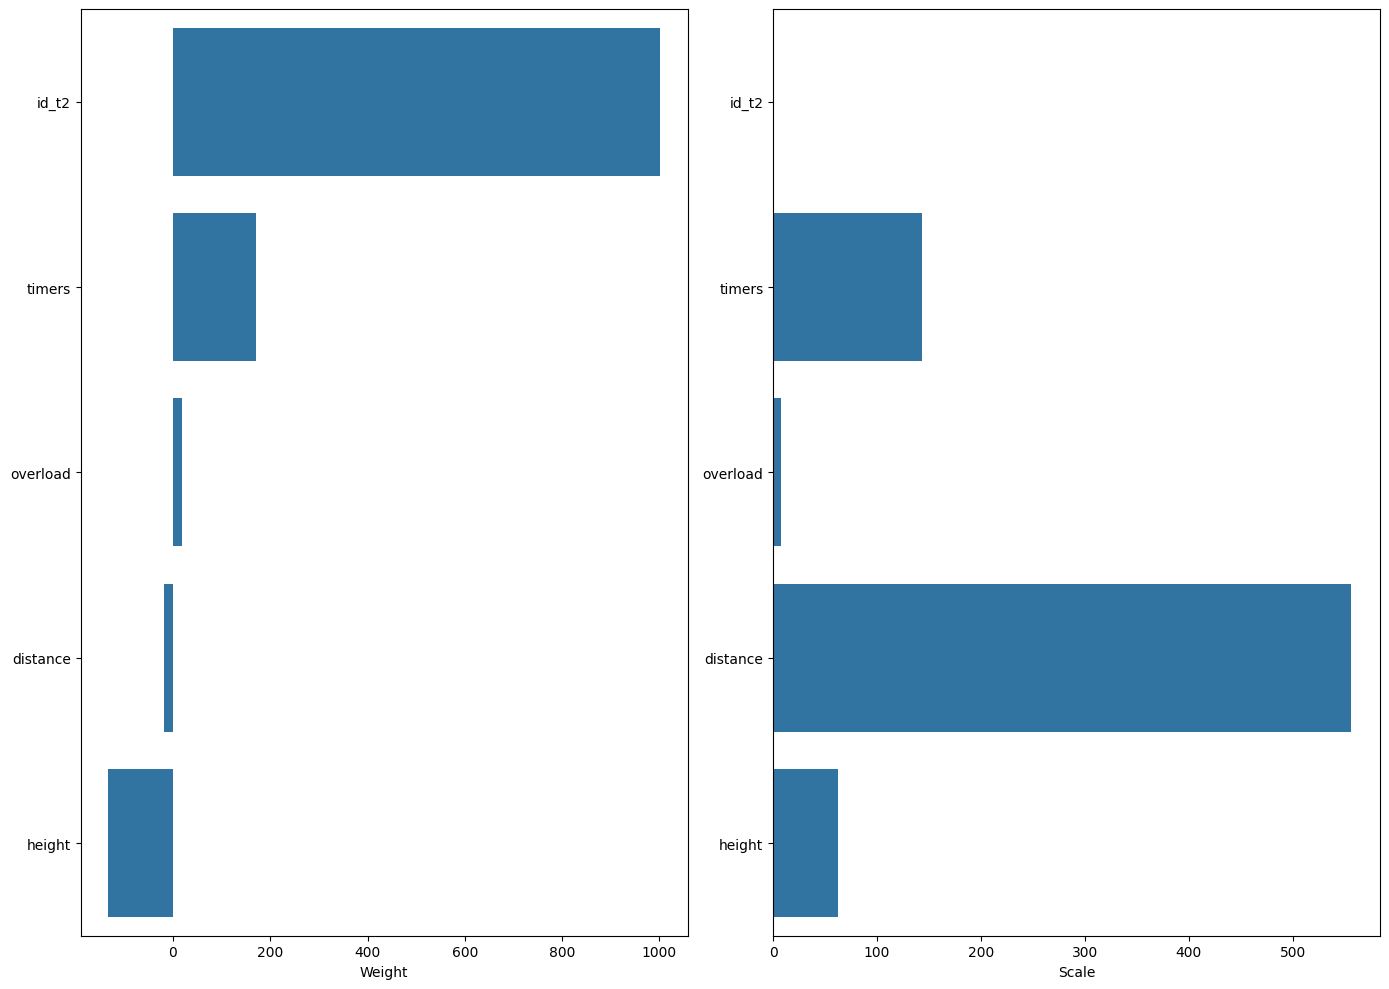

In [14]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print('Test RMSE = %.4f' % rmse(y_test, y_pred))
print('Train RMSE = %.4f' % rmse(y_train, y_train_pred))

Test RMSE = 514.6647
Train RMSE = 492.7739


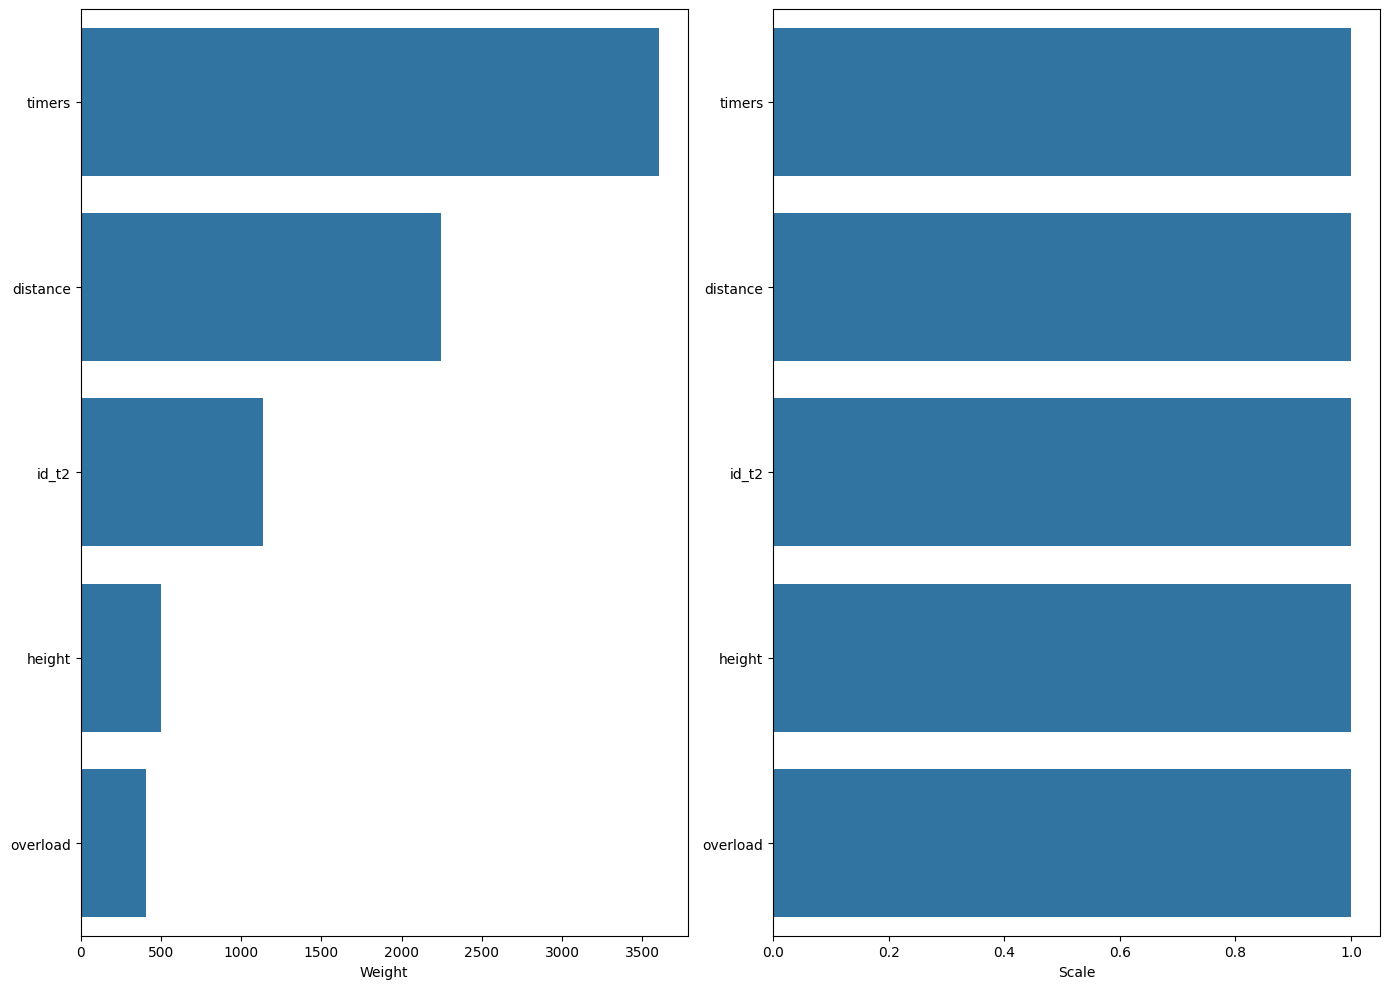

In [16]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

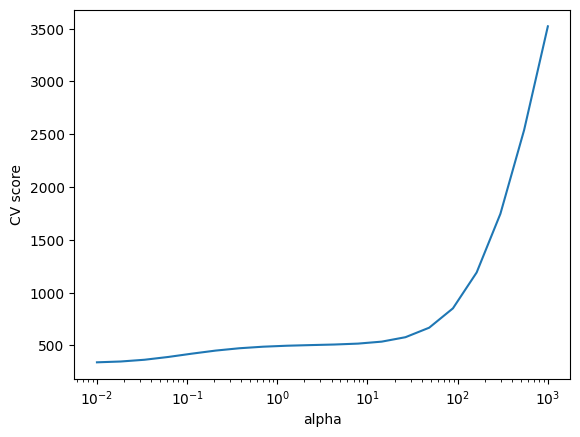

In [17]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)

searcher = GridSearchCV(Ridge(), [{'alpha': alphas}], scoring=rmse_scorer, cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_['alpha']

print('Best alpha = %.4f' % best_alpha)
plt.plot(alphas, -searcher.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV score')

In [18]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
  ('scaling', StandardScaler()),
  ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])

print('Test RMSE = %.4f' % rmse(y_test, y_pred))

Test RMSE = 357.3341
